## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

##  Шаг 1. Откройте файл с данными и изучите общую информацию


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')

In [3]:
df_int = pd.read_csv('/datasets/internet.csv')

In [4]:
df_mes = pd.read_csv('/datasets/messages.csv')

In [5]:
df_tar= pd.read_csv('/datasets/tariffs.csv')

In [6]:
df_user = pd.read_csv('/datasets/users.csv')

## Ознакомимся с тарифами

In [7]:
df_tar.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
# Переведем мегабайты в гигабайты в столбце mb_per_month_included и переименуем
df_tar['mb_per_month_included'] =  df_tar['mb_per_month_included']/1024  
df_tar = df_tar.rename(columns={'mb_per_month_included':'gb_per_month_included'})  

## Итог

С тарифами ознакомились, гигабайты в мегабайты перевли, на этом все)

## Изучим следующий датасет со звонками:

In [9]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [10]:
# посмотрим общую информацию о датасете
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [11]:
# Сразу хочу заметить не подходящий для иследования формаь для столбца call_date, исправим это
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format="%Y-%m-%dT")

In [12]:
# Проверка на дубликаты
df_calls.duplicated().sum()

0

In [13]:
# Посмотрим, есть ли пропущенные значения
df_calls.isnull().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [14]:
#Для анализа добавим столбец месяца
df_calls['month'] = df_calls['call_date'].dt.month_name()

С этим датафреймом проблем нет - дубликатов нет, пропуски отсутствуют, изменили лишь формат данных в столюце call_date, добавили отдельные столбец по месяцам.

Проанализируем его сожержимое

In [15]:
df_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,July
1,1000_1,2018-08-17,0.00,1000,August
2,1000_2,2018-06-11,2.85,1000,June
3,1000_3,2018-09-21,13.80,1000,September
4,1000_4,2018-12-15,5.18,1000,December


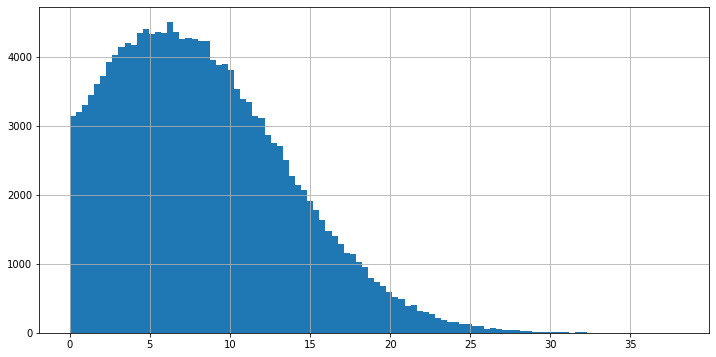

In [112]:
# Посмотрим гистограмму для первых выводов
df_calls['duration'].hist(bins= 100, figsize= (12,6))

In [17]:
# Посчитаем количество "нулевых" звонков
len(df_calls.query('duration <= 0'))

39613

Нулевых звонков очень много...

In [18]:
#Проверим, к одному ли тарифу относятся пропуски
add_tariff = dict(pd.Series(df_user['tariff'].values, index=df_user['user_id']))
df_calls['tariff'] = df_calls['user_id'].map(add_tariff)
df_calls['tariff'].value_counts()

smart    130315
ultra     72292
Name: tariff, dtype: int64

Теория не подтвердилась, смело дропаем 0)

Скорее всего это сбои в системе, или такие случаи, когда один абонент не смог дозвониться до другого по причине
"абонент разговаривает","не в зоне действия сети", или просто занят)

In [19]:
df_calls['duration'] = df_calls['duration'].replace(0, np.NaN)

In [20]:
df_calls = df_calls.dropna()
df_calls

,id,call_date,duration,user_id,month,tariff
2,1000_2,2018-06-11,2.85,1000,June,ultra
3,1000_3,2018-09-21,13.80,1000,September,ultra
4,1000_4,2018-12-15,5.18,1000,December,ultra
7,1000_7,2018-08-22,18.31,1000,August,ultra
8,1000_8,2018-09-15,18.44,1000,September,ultra
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,December,smart
202603,1499_216,2018-10-18,18.83,1499,October,smart
202604,1499_217,2018-11-10,10.81,1499,November,smart
202605,1499_218,2018-10-06,4.27,1499,October,smart


In [21]:
# Проанализируем продолжительность среднего звонка по месяцам
top_month = df_calls.groupby('month').agg({'duration':'mean'})
top_month  = top_month.sort_values('duration', ascending=False)
top_month

,duration
month,
January,8.768419
February,8.556591
March,8.440247
September,8.419375
July,8.414968
October,8.414229
August,8.406538
December,8.399129
June,8.387536


С не большим отрывом лидирует февраль, но в целом по году связь одинково востребована, что логично.

 ## Итог
 
 Огромное количество значения 0 для длительности звонков, а именно 39613. 

 По теории, пропуски могли относиться к одному тарифу, где не корректно работало округление, собрал данные из df_users и применив их в анализируемому датасету, выяснили, пропуски присутствовали в двух тарифах, поэтому и дропнули 0. 

 Связь актуальна в любой месяц года, средняя продолжительность звонка стоставляет 6-7 минут.


In [22]:
from IPython.display import display
from ipywidgets import Checkbox

cb1 = Checkbox(
    value= True,
    description='Согласен' 
)

def on_button_clicked(b):
    print(cb1.value)

cb1.observe(on_button_clicked, names='value')
display(cb1)

Checkbox(value=True, description='Согласен')

 ## Посмотрим датасет по интернету:

In [23]:
# Вглянем на датасет
df_int.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [24]:
 # Переведем мегабайты в гигабайты и переименуем столбец
df_int['mb_used'] =  df_int['mb_used']/1024  
df_int = df_int.rename(columns={'mb_used':'gb_used'})         

In [25]:
# Посмотрим на его основные параметры
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
gb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [26]:
# Также перевед столбец session_date в формат даты
df_int['session_date'] = pd.to_datetime(df_int['session_date'], format="%Y-%m-%dT")

In [27]:
 # Проверим на дубликаты
df_int.duplicated().sum()

0

In [28]:
# И пропуски
df_int.isnull().sum()

Unnamed: 0      0
id              0
gb_used         0
session_date    0
user_id         0
dtype: int64

Дубликатов и пропусков не обнаруженно, и это отлично)

In [29]:
#Для анализа добавим  новый столбец по названию месяца
df_int['month'] = df_int['session_date'].dt.month_name()

In [30]:
# Проанализируем средний трафик по месяцам

top_month_int = df_int.groupby('month').agg({'gb_used':'mean'})
top_month_int  = top_month_int.sort_values('gb_used', ascending=False)
top_month_int

,gb_used
month,
June,0.369182
May,0.365989
April,0.364964
August,0.364005
July,0.362533
March,0.362205
October,0.360783
December,0.359671
September,0.359543


Опять все ровно, без интернета никуда!

## Итог
По данному датасету нет замечаний, пропуски и дубликаты не обнаружены, всего лишь поменяли формат столбца с датами и 
добавили столбец месяц для анализа трафика по месяцам. приступим к следующему.

## Посмотрим на датасет с сообщениями


In [31]:
# Посмотрим на датасет с сообщениями
df_mes.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [32]:
# Посмотрим на его параметры
df_mes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [33]:
# И опять применим функцию для изменения типа данных в столбце с датами и добавим сьтолбец с месяцем
df_mes['message_date'] = pd.to_datetime(df_mes['message_date'], format="%Y-%m-%dT")
df_mes['sms_month'] = df_mes['message_date'].dt.month_name()


In [34]:
# Посчитаем количество sms
sms_month = df_mes.pivot_table(index = 'sms_month', values = 'id', aggfunc = 'nunique')
sms_month

,id,sms_month
sms_month,,
April,5179,1
August,13088,1
December,20555,1
February,1924,1
January,924,1
July,11320,1
June,8983,1
March,3648,1
May,7298,1


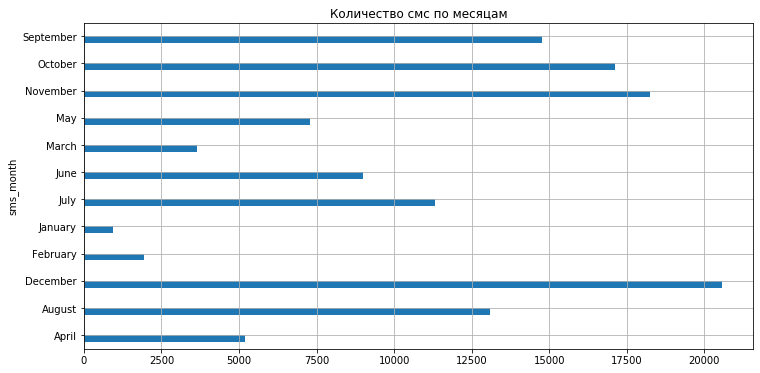

In [35]:
sms_month.plot(kind='barh', figsize=(12,6), grid = True, title = 'Количество смс по месяцам', legend=False)

Интересный разброс.

В лидерах Сентябрь, Октябрь, Ноябрь, Август. 
Если в Декабре можно предположить, что абоненты отправляют массово поздравления с Новым годом, то в остальные месяцы 
повышенная активность использования смс не понятна.

Имеем, что имеем.

In [36]:
# Проверим на дубликаты
df_mes.duplicated().sum()

0

In [37]:
# И на прпуски
df_mes.isnull().sum()

id              0
message_date    0
user_id         0
sms_month       0
dtype: int64

## Итог

C этим датасетом все в порядке, данных для анализы тут никаких нет, поменяли лишь тип данных в столбце с датами.
Выявилась своего рода аномалия по количеству отправленных смс, характеризующаяся выбивающимеся значениями по месяцам.
Теории по данной аномалии нет. 
Переходим дальше.

## Открываем последний датасет


In [38]:
df_user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [39]:
# Посмотрим общую информацию
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [40]:
# Изменим формат данных в столбцах churn_date и reg_date
df_user['churn_date'] = pd.to_datetime(df_user['churn_date'], format="%Y-%m-%dT")
df_user['reg_date'] = pd.to_datetime(df_user['reg_date'], format="%Y-%m-%dT")

In [41]:
# Проверим на дубликаты
df_user.duplicated().sum()

0

In [42]:
# И на пропуски
df_user.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Обнаружились пропуски в столбце churn_date (дата прекращения пользования тарифом), но согласно условию, 
если значение пропущено, то тариф ещё действовал на момент выгрузки данных, так что не обращаем внимание на это


In [43]:
#Для анализа добавим  новый столбец по названию месяца к churn_date и reg_date, а также год для reg_date

df_user['churn_date_month'] = df_user['churn_date'].dt.month_name()
df_user['reg_date_month'] = df_user['reg_date'].dt.month_name()
df_user['reg_date_year'] = df_user['reg_date'].dt.year

In [44]:
df_user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,churn_date_month,reg_date_month,reg_date_year
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,NaN,May,2018
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,NaN,November,2018
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,NaN,June,2018
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,NaN,August,2018
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,NaN,May,2018


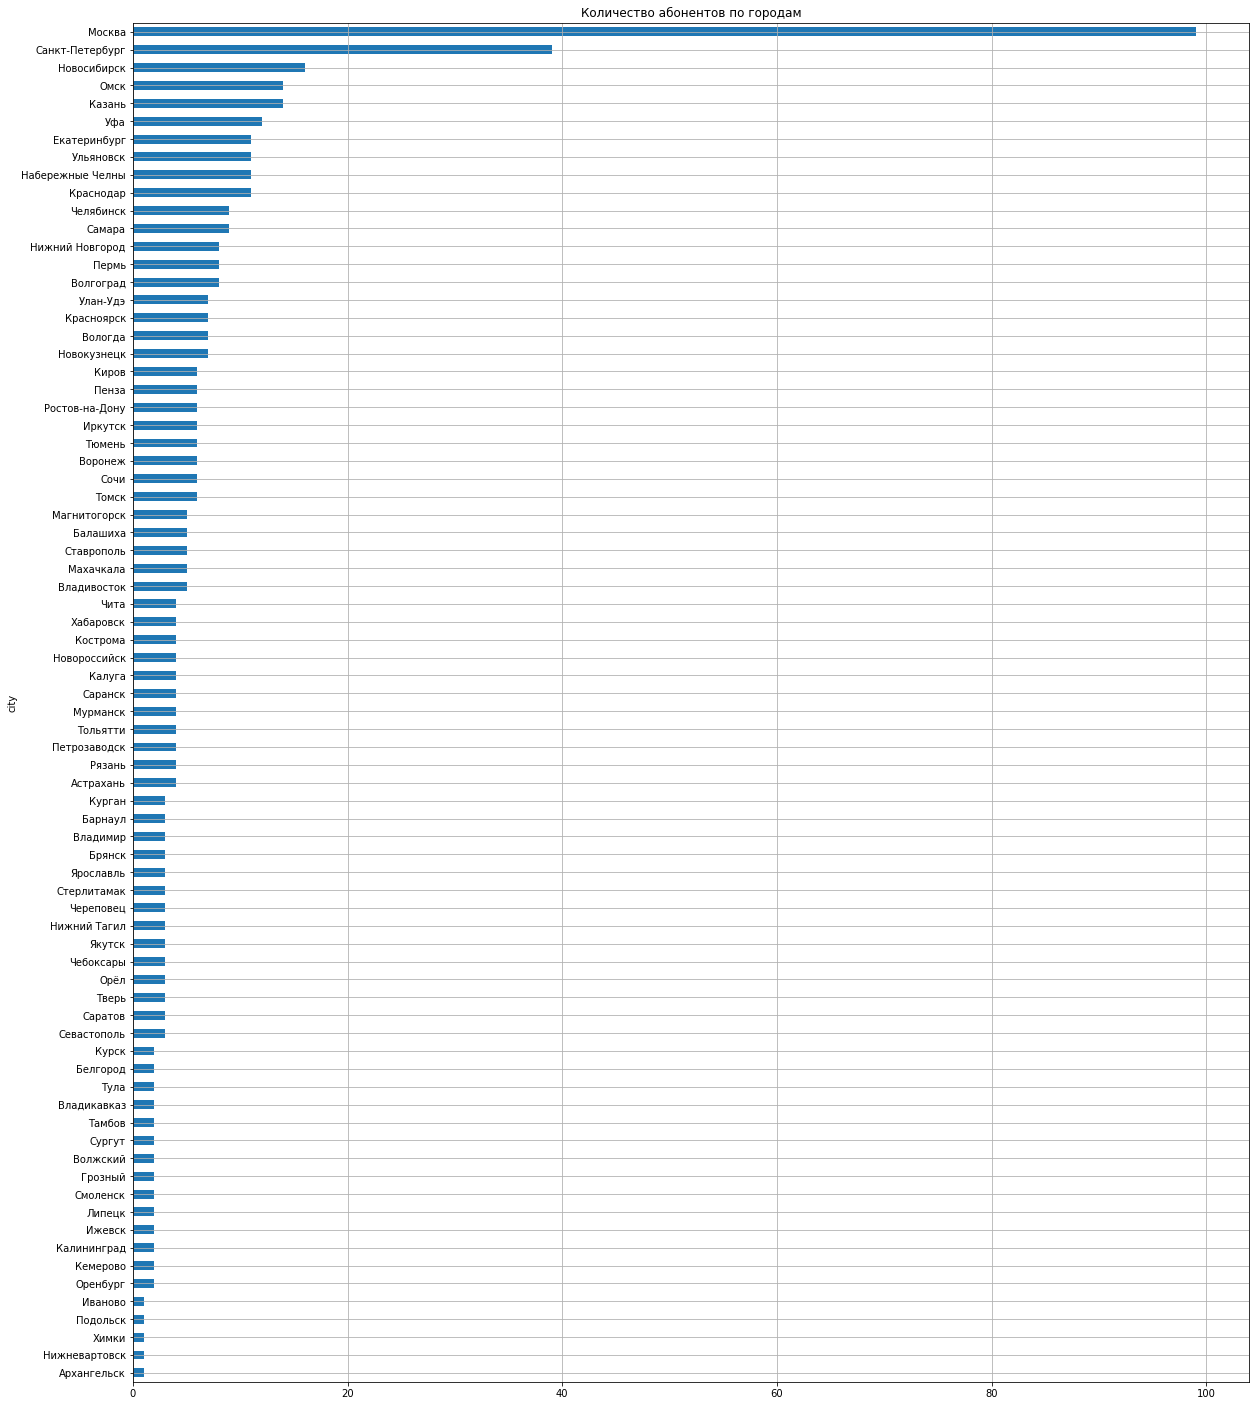

In [45]:
# Посмотрим количество абонентов по городам
city_id_count = df_user.groupby('city')\
    .agg({'user_id':'count'})
city_id_count  = city_id_count.sort_values('user_id', ascending=True)
city_id_count.plot(kind='barh', figsize=(20, 25), grid = True, title = 'Количество абонентов по городам', legend=False)

Как я и ожидал, большее количество абонентов находится в Москве и Петербруге

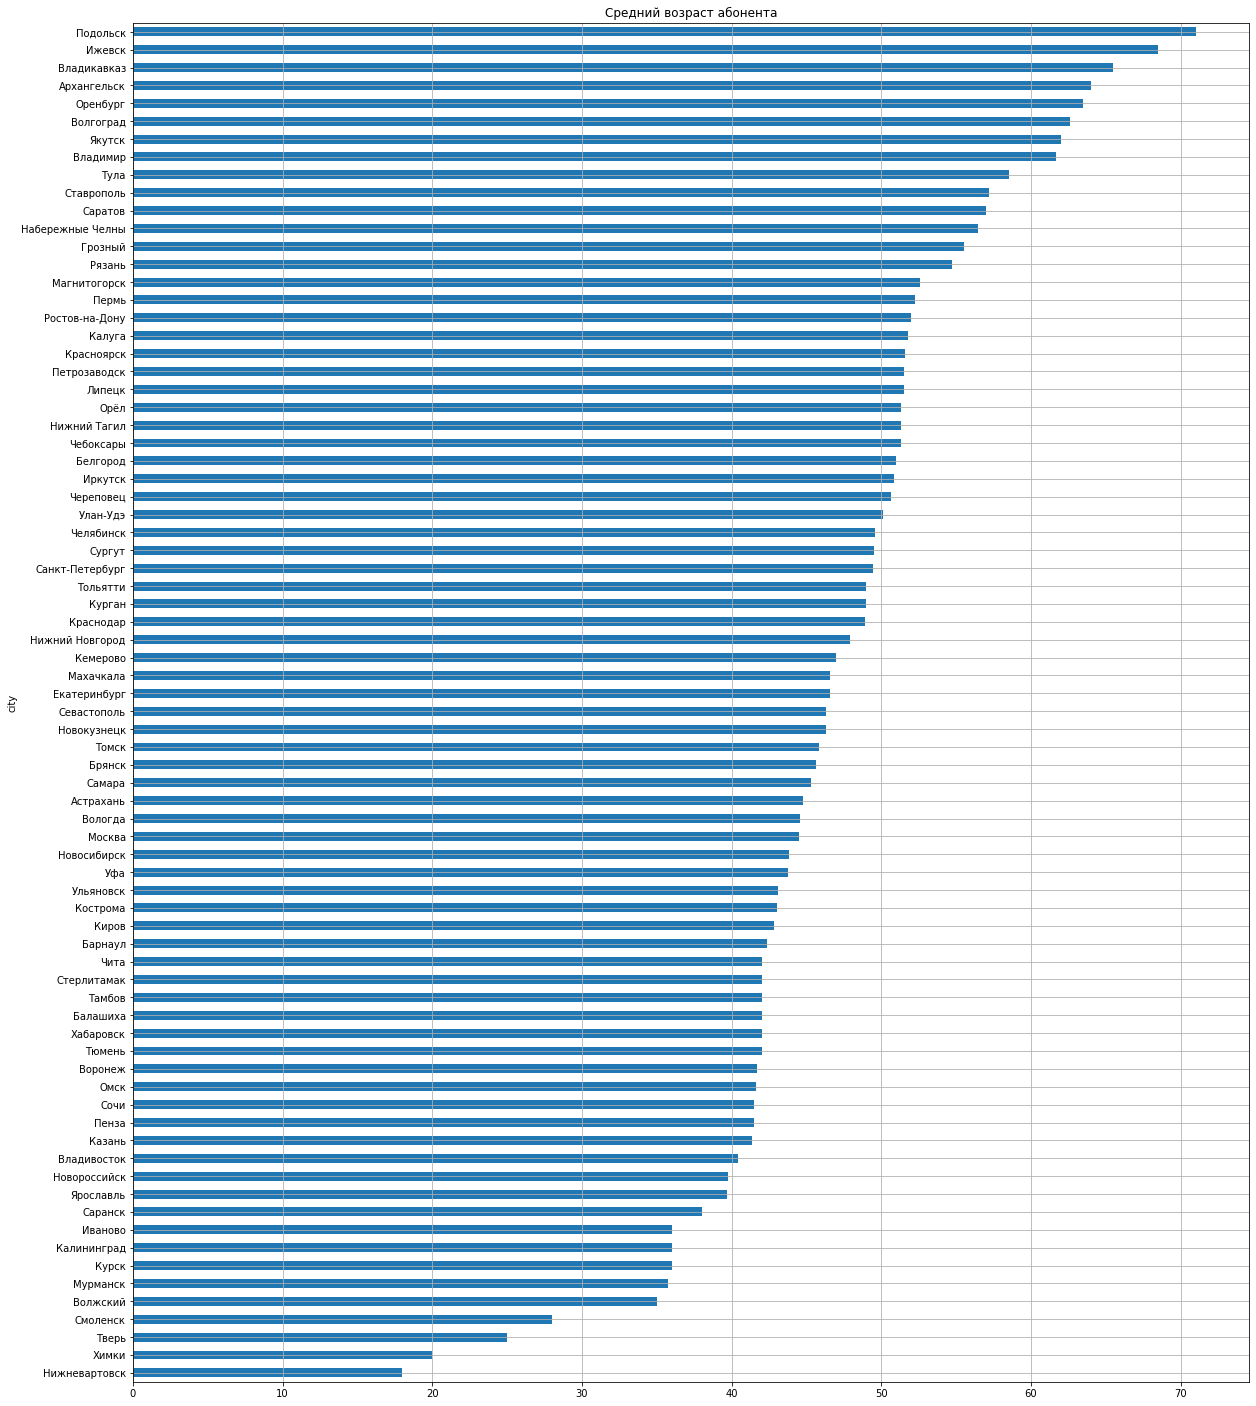

In [46]:
# Выясним средний возраст абонента оператора, попавшего в выборку, по горадам
mean_age_city = df_user.groupby('city')\
    .agg({'age':'mean'})
mean_age_city  = mean_age_city.sort_values('age', ascending=True)
mean_age_city.plot(kind='barh', figsize=(20, 25), grid = True, title = 'Средний возраст абонента', legend=False)

Как интересно!
В Подольске средний возраст попавшего в выборку абонента больше 70 лет, а в Нижневартовске 18, какова логика?

In [47]:
# Посмотрим: какой тариф популярней
tariff_1 = df_user.groupby('tariff')['user_id'].nunique()
tariff_1

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

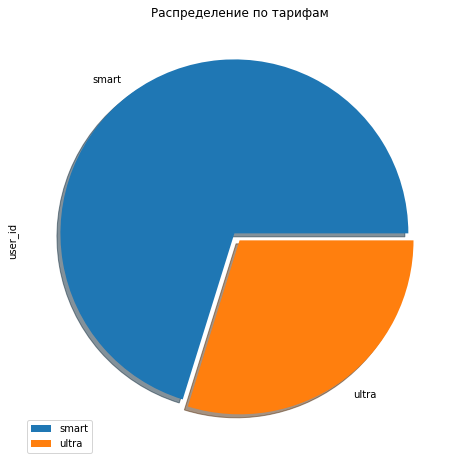

In [48]:
tariff_1.plot(kind= 'pie', figsize= (8,8), legend=True, title = 'Распределение по тарифам', explode = (0.05, 0), shadow=True)

По каким-то причинам абоненты выбирают тариф smart, интересно почему?

In [49]:
# Посмотрим приток клиентов по месяцам
reg_date_month = df_user.groupby('reg_date_month')['user_id'].nunique()
reg_date_month

reg_date_month
April        53
August       50
December     36
February     39
January      43
July         44
June         40
March        32
May          41
November     42
October      45
September    35
Name: user_id, dtype: int64

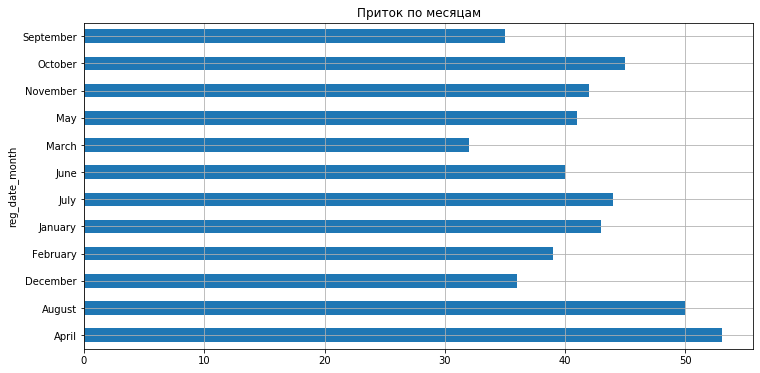

In [50]:
# Отобразим на графике приток по месяцам
reg_date_month.plot(kind='barh', figsize=(12,6), grid = True, title = 'Приток по месяцам')

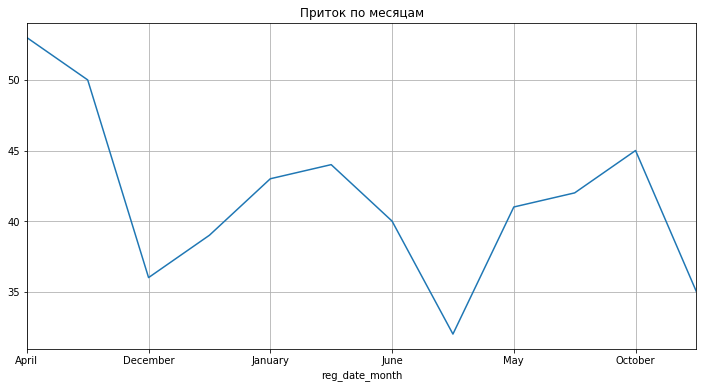

In [51]:
# Отобразим на графике динамику
reg_date_month.plot(figsize=(12,6), grid = True, title = 'Приток по месяцам')

Что мы видим? Самый массовый приток клиентов у нас был в августе и апреля, на графике с кривой видно, что динамика прироста скачет, и не я вляется стабильной , что-бы расти надо принять меры.

In [52]:
# Теперь посмотрим на отток клиентов
churn_date_month= df_user.dropna(subset=['churn_date_month'])

In [53]:
churn_date_month = churn_date_month.groupby('churn_date_month')['user_id'].nunique()

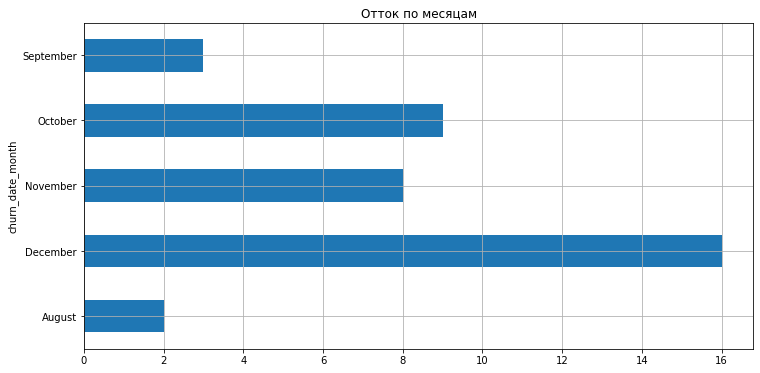

In [54]:
# Отобразим на графике отток по месяцам
churn_date_month.plot(kind='barh', figsize=(12,6), grid = True, title = 'Отток по месяцам')

Видем, что в декабре мы чем-то насолили клиенту, что он от нас ушел, надо бы выяснить почему

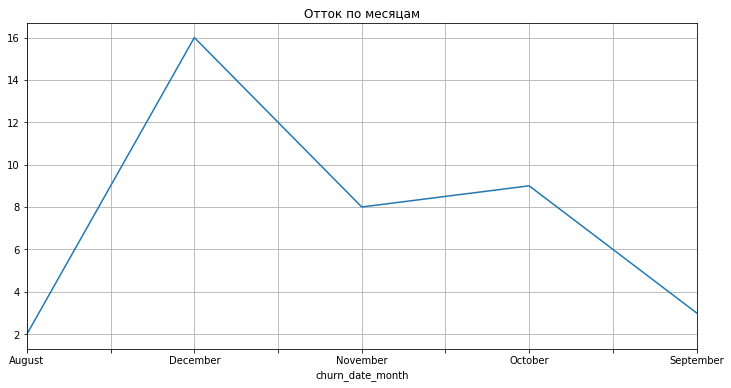

In [55]:
# Отобразим на графике динамику
churn_date_month.plot(figsize=(12,6), grid = True, title = 'Отток по месяцам')

Самый массовый отток клиентов мы получили в декабре, динамика оттока также не стабильна, как и приток.

## Общий вывод

Открыли и проанализировали прежложенные нам датасеты с информацией по клиентам и услугами.

Даные без проспусков и дубликатов, за исключением нулевых значений длительности звонков, которые мы удалили, опираясь на теорию, доказанную выше. Кроме этого, для детального анализа, я добавил столбцы по месяцам для более детального анализа.

Что мы выяснилии:

1. Продолжительность среднего звонка по месяцам не отличается, и в рамках погрешностей примерно одинаковая

2. Спрос на интернет есть всегда, средний размер потребляемого трафика по месяцам примерно одинаковый.

3. Не однородный спрос на услуги смс сообщений.Если в Декабре можно предположить, что абоненты отправляют массово поздравления с Новым годом, то в остальные месяцы повышенная активность использования смс не понятна.

4. Обнаружились пропуски в столбце churn_date (дата прекращения пользования тарифом), но согласно условию, если значение пропущено, то тариф ещё действовал на момент выгрузки данных, так что не обращаем внимание на это.

    Как я и ожидал, большее количество абонентов находится в Москве и Петербруге.
    
    Большинство абонентов сети пользуются тарифом смарт.
    
    Не равномерная выборка абонентов по возрасту относительно города.
    
    В Подольске средний возраст попавшего в выборку абонента больше 70 лет, а в Нижневартовске 18, какова логика?
    
    Могу предположить6 что ошибки в срезах данных при стоставлении выборки.
    
    Самый массовый приток клиентов у нас был в августе и апреля, на графике с кривой видно, что динамика прироста скачет, и не я вляется стабильной , что-бы расти надо принять меры.
    
    В декабре произошел самый массовый отток клиентов, надо бы выяснить почему...динамика оттока также не стабильна, как и приток.
    

    




## Объеденим датасаеты в один!

In [56]:
# Сгрупируем необходимые данные по кажому датасету
calls = df_calls.groupby(['user_id','month'])['duration'].agg(['count', 'sum'])
messages = df_mes.groupby(['user_id', 'sms_month'])['id'].count()
internet = df_int.groupby(['user_id', 'month']).sum()['gb_used']

In [57]:
# Соеденим все в один датафрейм и вывыедем на экран
df_group = pd.concat([calls, messages, internet], axis=1).reset_index()
df_group.head()

,level_0,level_1,count,sum,id,gb_used
0,1000,August,42.0,389.87,81.0,13.726494
1,1000,December,38.0,312.98,70.0,9.587510
2,1000,July,41.0,318.80,75.0,13.675430
3,1000,June,28.0,158.90,60.0,22.689229
4,1000,May,17.0,150.06,22.0,2.200674


In [58]:
# Добавим столбцы с тарифом и городом 

# Для начала добавим тариф
add_tariff = dict(pd.Series(df_user['tariff'].values, index = df_user['user_id'])) 
df_group['tariff'] = df_group['level_0'].map(add_tariff)
# теперь добавим город 
add_city = dict(pd.Series(df_user['city'].values, index = df_user['user_id']))
df_group['city']= df_group['level_0'].map(add_city)

In [59]:
df_group.head()

,level_0,level_1,count,sum,id,gb_used,tariff,city
0,1000,August,42.0,389.87,81.0,13.726494,ultra,Краснодар
1,1000,December,38.0,312.98,70.0,9.587510,ultra,Краснодар
2,1000,July,41.0,318.80,75.0,13.675430,ultra,Краснодар
3,1000,June,28.0,158.90,60.0,22.689229,ultra,Краснодар
4,1000,May,17.0,150.06,22.0,2.200674,ultra,Краснодар


In [60]:
# Переименуем столбцы
df_group = df_group.rename(columns={'level_0':'user_id'})  
df_group = df_group.rename(columns={'level_1':'month'})
df_group = df_group.rename(columns={'level_1':'month'})
df_group = df_group.rename(columns={'count':'vyzov'})
df_group = df_group.rename(columns={'id':'sms'})
df_group = df_group.rename(columns={'sum':'minutes'})

df_group.head()


,user_id,month,vyzov,minutes,sms,gb_used,tariff,city
0,1000,August,42.0,389.87,81.0,13.726494,ultra,Краснодар
1,1000,December,38.0,312.98,70.0,9.587510,ultra,Краснодар
2,1000,July,41.0,318.80,75.0,13.675430,ultra,Краснодар
3,1000,June,28.0,158.90,60.0,22.689229,ultra,Краснодар
4,1000,May,17.0,150.06,22.0,2.200674,ultra,Краснодар


Отличная получилась таблица! Выполним предобработку данных!

In [61]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id    3214 non-null int64
month      3214 non-null object
vyzov      3168 non-null float64
minutes    3168 non-null float64
sms        2717 non-null float64
gb_used    3203 non-null float64
tariff     3214 non-null object
city       3214 non-null object
dtypes: float64(4), int64(1), object(3)
memory usage: 201.0+ KB


In [62]:
df_group.isnull().sum()

user_id      0
month        0
vyzov       46
minutes     46
sms        497
gb_used     11
tariff       0
city         0
dtype: int64

Обнаружились пропуски, но это можно исправить, заменив их средними значениями из данных, приступим!

In [63]:
# Заменим пропуски средними значениями с стобцах minutes, sms, gb_used ,vyzov
df_group['minutes'] = df_group['minutes'].transform(lambda x: x.fillna(x.mean()))
df_group['sms'] = df_group['sms'].transform(lambda x: x.fillna(x.mean()))
df_group['gb_used'] = df_group['gb_used'].transform(lambda x: x.fillna(x.mean()))
df_group['vyzov'] = df_group['vyzov'].transform(lambda x: x.fillna(x.mean()))

In [64]:
df_group.isnull().sum()

user_id    0
month      0
vyzov      0
minutes    0
sms        0
gb_used    0
tariff     0
city       0
dtype: int64

Пропуски заполнены!

In [65]:
# Проверим на дубликаты
df_group.duplicated().sum()

0

Дубликатов нет, и это хорошо!

## Добавим информации о месячной выручке для каждого абонента

In [66]:
# Для начала добавим столбец с абоненсткой платой
ap = {'smart': 550, 'ultra': 1950}
df_group['ap'] = df_group['tariff'].map(ap)
df_group.head()

,user_id,month,vyzov,minutes,sms,gb_used,tariff,city,ap
0,1000,August,42.0,389.87,81.0,13.726494,ultra,Краснодар,1950
1,1000,December,38.0,312.98,70.0,9.587510,ultra,Краснодар,1950
2,1000,July,41.0,318.80,75.0,13.675430,ultra,Краснодар,1950
3,1000,June,28.0,158.90,60.0,22.689229,ultra,Краснодар,1950
4,1000,May,17.0,150.06,22.0,2.200674,ultra,Краснодар,1950


Добавление столбца прошло успешно) Продолжим!

In [67]:
# Напишем функицю для столбцов перерасход для каждого исчислимого столбца
def minutes_over(row):
    if row['tariff'] == 'smart':
        result = row['minutes'] - 500
        return np.where(result > 0, result, 0)
    else:
        result = row['minutes'] - 3000
        return np.where(result > 0, result, 0)
    
    
def sms_over(row):
    if row['tariff'] == 'smart':
        result = row['sms'] - 50
        return np.where(result > 0, result, 0)
    else:
        result =  row['sms'] - 1000
        return np.where(result > 0, result, 0)
    

def gb_over(row):
    if row['tariff'] == 'smart':
        result = row['gb_used'] - 15 
        return np.where(result > 0, result, 0)
    else:
        result = row['gb_used'] - 30 
        return np.where(result > 0, result, 0)
    
    
def month_over(row):
    sum_per_month = 0
    if row['tariff'] == 'smart':
        sum_per_month += np.ceil(row['minutes_over']) * 3
        sum_per_month += row['sms_over'] * 3
        sum_per_month += np.ceil(row['gb_over']) * 200
        return sum_per_month
    
    else:
        sum_per_month += np.ceil(row['minutes_over']) * 1
        sum_per_month += row['sms_over'] * 1
        sum_per_month += np.ceil(row['gb_over']) * 150
        return sum_per_month

In [68]:
# Теперь создадим столбцы
df_group['minutes_over'] = df_group.apply(minutes_over, axis=1)
df_group['sms_over'] = df_group.apply(sms_over, axis=1)
df_group['gb_over'] = df_group.apply(gb_over, axis=1)
df_group['month_over'] = df_group.apply(month_over, axis=1)
df_group.sample(20)

,user_id,month,vyzov,minutes,sms,gb_used,tariff,city,ap,minutes_over,sms_over,gb_over,month_over
2316,1367,November,29.000000,250.700000,45.283769,10.672168,ultra,Москва,1950,0.0,0.0,0.0,0.0
1067,1169,August,55.000000,432.220000,14.000000,18.532939,smart,Сочи,550,0.0,0.0,3.5329394531249996,800.0
806,1126,April,74.000000,651.970000,6.000000,26.546016,ultra,Санкт-Петербург,1950,0.0,0.0,0.0,0.0
51,1006,October,35.000000,249.930000,45.283769,19.234961,smart,Ульяновск,550,0.0,0.0,4.234960937499995,1000.0
344,1055,February,56.000000,412.910000,25.000000,14.394258,smart,Казань,550,0.0,0.0,0.0,0.0
2346,1373,April,51.450126,432.067563,48.000000,19.898223,smart,Улан-Удэ,550,0.0,0.0,4.898222656249999,1000.0
888,1142,May,51.000000,445.880000,42.000000,23.084951,smart,Новосибирск,550,0.0,0.0,8.084951171874987,1800.0
2023,1319,November,80.000000,661.180000,52.000000,17.904434,smart,Санкт-Петербург,550,161.17999999999995,2.0,2.9044335937499994,1092.0
399,1063,October,99.000000,943.930000,45.283769,13.861387,ultra,Тула,1950,0.0,0.0,0.0,0.0
2840,1440,December,23.000000,188.570000,105.000000,23.190117,ultra,Москва,1950,0.0,0.0,0.0,0.0


In [69]:
# Добавление прошло успешно, но формат знаяений не очень удобен, изменим тип данных


for column in ['minutes', 'minutes_over', 'gb_used', 'gb_over']:
    df_group[column] = df_group[column].astype('float')
    
for column in ['sms','sms_over', 'month_over','ap','month_over']:
    df_group[column] = df_group[column].astype('int')
    

In [70]:

df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 13 columns):
user_id         3214 non-null int64
month           3214 non-null object
vyzov           3214 non-null float64
minutes         3214 non-null float64
sms             3214 non-null int64
gb_used         3214 non-null float64
tariff          3214 non-null object
city            3214 non-null object
ap              3214 non-null int64
minutes_over    3214 non-null float64
sms_over        3214 non-null int64
gb_over         3214 non-null float64
month_over      3214 non-null int64
dtypes: float64(5), int64(5), object(3)
memory usage: 326.5+ KB


In [71]:
# Теперь добавим столбец с общей выручкой по каждома клиенту
df_group['month_$'] = df_group[['ap','month_over']].sum(axis=1)


df_group.sample(5)
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id         3214 non-null int64
month           3214 non-null object
vyzov           3214 non-null float64
minutes         3214 non-null float64
sms             3214 non-null int64
gb_used         3214 non-null float64
tariff          3214 non-null object
city            3214 non-null object
ap              3214 non-null int64
minutes_over    3214 non-null float64
sms_over        3214 non-null int64
gb_over         3214 non-null float64
month_over      3214 non-null int64
month_$         3214 non-null int64
dtypes: float64(5), int64(6), object(3)
memory usage: 351.7+ KB


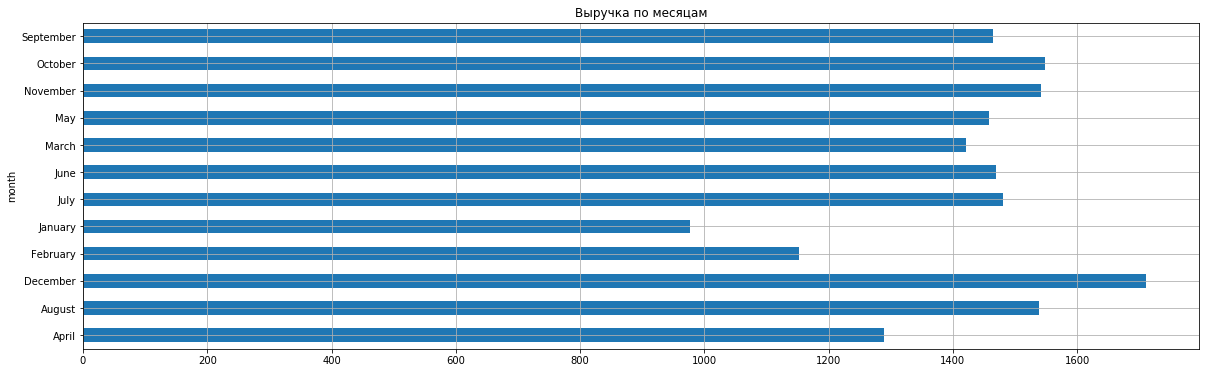

In [72]:
# Посмотрим на ежемесячную выручку

mean_value = df_group.pivot_table(index= 'month', values = 'month_$', aggfunc = 'mean')
mean_value.plot(kind = 'barh', figsize = (20,6), grid=True, title = 'Выручка по месяцам',legend=False)

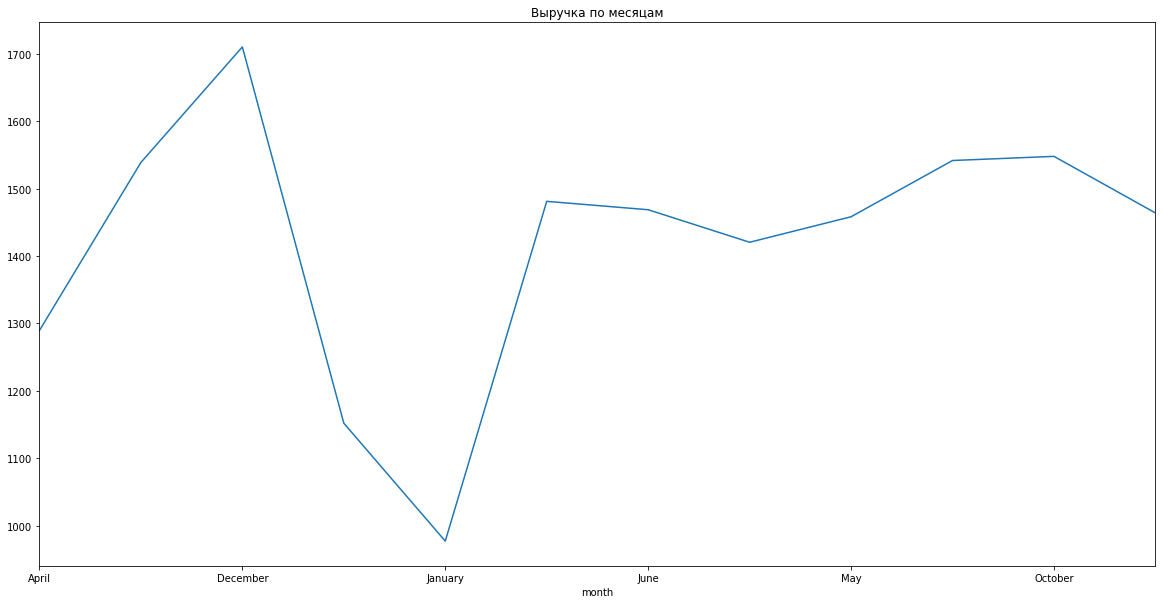

In [73]:
month_v = df_group.pivot_table(index= 'month', values = 'month_$', aggfunc = 'mean')
month_v.plot(figsize = (20,10),title = 'Выручка по месяцам',legend=False)

На графиках видно , как сильно скачет выручка, несмотря на то, что спрос на связь и интернет стабилен, а вот на смс нет.

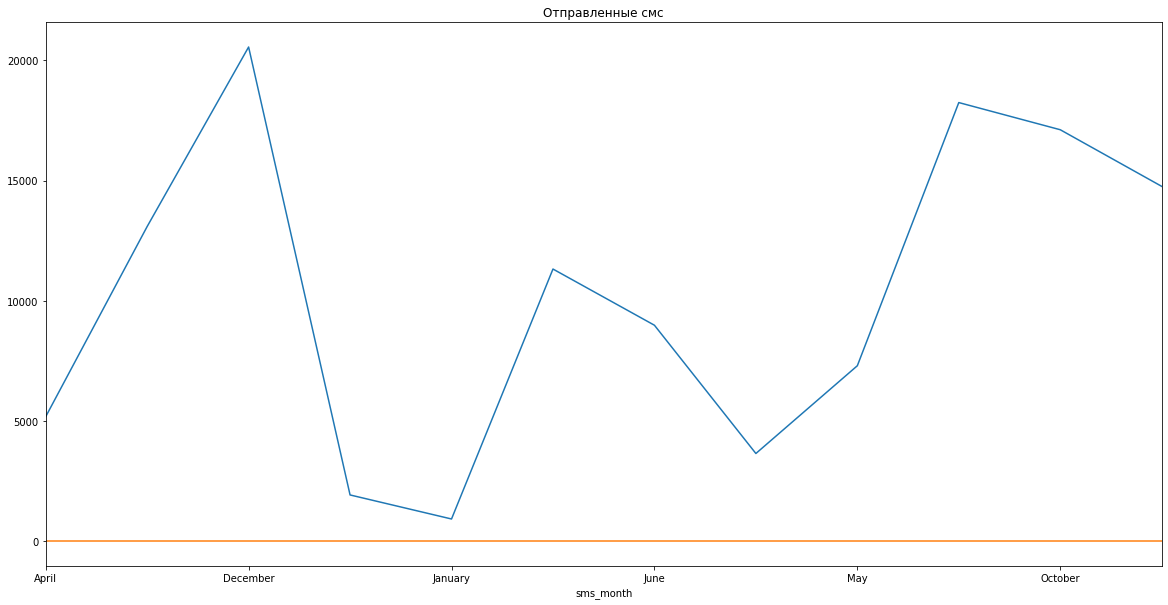

In [74]:
sms_month.plot(figsize = (20,10),title = 'Отправленные смс',legend=False)

На графике очевидны схожести пиков падения и роста выручки и падения и рост числа отправленных смс... совпадение? 



In [75]:
# Проверим вышеуказанную теорию
sms1 = df_group.pivot_table(index = 'month',values = ['sms', 'minutes', 'gb_used', 'month_$'], aggfunc = 'mean')
sms1.corr()

,gb_used,minutes,month_$,sms
gb_used,1.000000,0.985925,0.989029,0.984528
minutes,0.985925,1.000000,0.976918,0.990965
month_$,0.989029,0.976918,1.000000,0.972404
sms,0.984528,0.990965,0.972404,1.000000


Теория не оправдалась, смс меньше всего влияют на месячную вырочку, а схожесть графиков всего лишь совпадение

In [76]:
# Разметим клиентов по критерию "переплатил" или "не переплатил", где 0 это "не переплатил", а 1 это "переплатил"
df_group['over_or_no_over'] = np.where(df_group['month_over'] > 0, 1, 0)
df_group

,user_id,month,vyzov,minutes,sms,gb_used,tariff,city,ap,minutes_over,sms_over,gb_over,month_over,month_$,over_or_no_over
0,1000,August,42.0,389.87,81,13.726494,ultra,Краснодар,1950,0.0,0,0.000000,0,1950,0
1,1000,December,38.0,312.98,70,9.587510,ultra,Краснодар,1950,0.0,0,0.000000,0,1950,0
2,1000,July,41.0,318.80,75,13.675430,ultra,Краснодар,1950,0.0,0,0.000000,0,1950,0
3,1000,June,28.0,158.90,60,22.689229,ultra,Краснодар,1950,0.0,0,0.000000,0,1950,0
4,1000,May,17.0,150.06,22,2.200674,ultra,Краснодар,1950,0.0,0,0.000000,0,1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,September,53.0,446.68,44,21.615635,smart,Владикавказ,550,0.0,0,6.615635,1400,1950,1
3210,1499,December,56.0,465.16,66,12.749590,smart,Пермь,550,0.0,16,0.000000,48,598,1
3211,1499,November,62.0,576.50,59,17.542295,smart,Пермь,550,76.5,9,2.542295,858,1408,1
3212,1499,October,44.0,429.91,48,17.371592,smart,Пермь,550,0.0,0,2.371592,600,1150,1


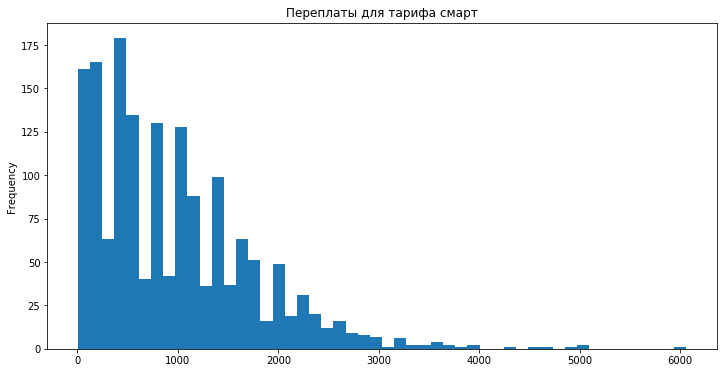

In [77]:
# Построим график для переплат для тарифа смарт 
df_filtered_smart = df_group[(df_group['tariff'] == 'smart') & (df_group['month_over'] > 0)]['month_over']
df_filtered_smart.plot(kind='hist', bins=50,figsize= (12,6), title = 'Переплаты для тарифа смарт')

Большинство значений лежит в районе до 1500 рублей. Учитывая, что размер абонентский платы - 550 рублей, это много.


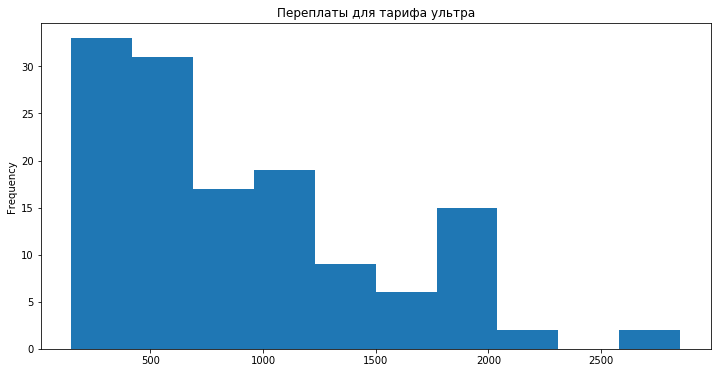

In [78]:
df_filtered_ultra = df_group[(df_group['tariff'] == 'ultra') & (df_group['month_over'] > 0)]['month_over']
df_filtered_ultra.plot(kind='hist', bins=10,figsize= (12,6), title = 'Переплаты для тарифа ультра')

Большинство значений лежит в районе до 200 рублей.

In [79]:
df_group.head()

,user_id,month,vyzov,minutes,sms,gb_used,tariff,city,ap,minutes_over,sms_over,gb_over,month_over,month_$,over_or_no_over
0,1000,August,42.0,389.87,81,13.726494,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
1,1000,December,38.0,312.98,70,9.587510,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
2,1000,July,41.0,318.80,75,13.675430,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
3,1000,June,28.0,158.90,60,22.689229,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
4,1000,May,17.0,150.06,22,2.200674,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0


In [80]:
# Посмотрим, какие услуги чаще всего заказывают дополнительно на кажлом тарифе
(df_group.groupby('tariff').sum()[['minutes_over', 'sms_over', 'gb_over']]).reset_index()


,tariff,minutes_over,sms_over,gb_over
0,smart,68358.34,12928,6000.386962
1,ultra,0.00,0,721.472559


Клиентам тарифа Ультра минут и смс хватает, а вот гигабайт - нет, в то время, как на смарте абоненты докупает все три услуги.

## Отбросим выбросы из нашего датасета

In [81]:
df_group.head()

,user_id,month,vyzov,minutes,sms,gb_used,tariff,city,ap,minutes_over,sms_over,gb_over,month_over,month_$,over_or_no_over
0,1000,August,42.0,389.87,81,13.726494,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
1,1000,December,38.0,312.98,70,9.587510,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
2,1000,July,41.0,318.80,75,13.675430,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
3,1000,June,28.0,158.90,60,22.689229,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0
4,1000,May,17.0,150.06,22,2.200674,ultra,Краснодар,1950,0.0,0,0.0,0,1950,0


In [82]:
# Напишем функцию для фильтрации необходимых нам параметров
def vybros(df_group, column,graphic=0,x=5,y=5):
    q1 = df_group[column].quantile(0.25)                 
    q3 = df_group[column].quantile(0.75)
    iqr = q3 - q1
    filt = (df_group[column] >= (q1 - 1.5*iqr)) & (df_group[column] <= (q3 + 1.5*iqr))
    if graphic == 1:
        return df_group.loc[filt].boxplot([column], figsize=(x,y))
    else:
        return df_group.loc[filt]

(-20, 1000)

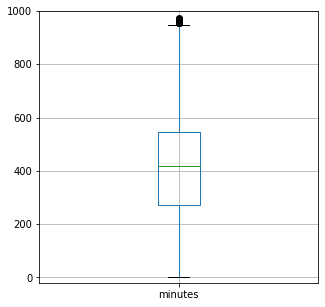

In [83]:
#  Посмотрим на график продолжительности звонков
vybros(df_group,'minutes',1,5,5).set_ylim(-20,1000)

In [84]:
df_group['minutes'].describe()

count    3214.000000
mean      432.067563
std       222.730069
min         0.100000
25%       276.372500
50%       424.535000
75%       555.030000
max      1578.060000
Name: minutes, dtype: float64

После фильтрации данных столбца с продолжительностью звонков , 

основные значения лежат в диапозоне от 275 до 555 минут, среднее значение 223 минуты

(-20, 120)

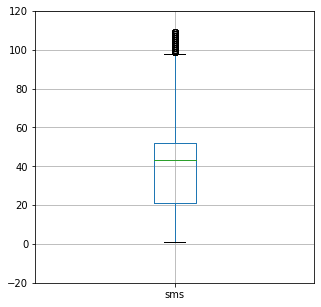

In [85]:
# Посмотрим на график отправленных смс
vybros(df_group,'sms',1,5,5).set_ylim(-20,120)

In [86]:
df_group['sms'].describe()

count    3214.000000
mean       45.239888
std        32.226759
min         1.000000
25%        22.000000
50%        45.000000
75%        57.000000
max       224.000000
Name: sms, dtype: float64

После фильтрации данных столбца с смс , основыные значения лежат в диапозоне от 22 до 57 смс,

среднее значение 32 смс

(-10, 40)

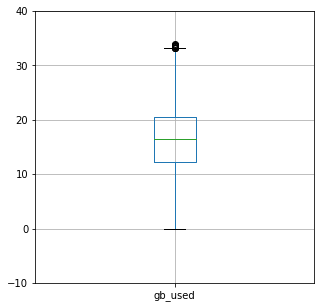

In [87]:
# Посмотрим на график интернет траффика
vybros(df_group,'gb_used',1,5,5).set_ylim(-10,40)

In [88]:
df_group['gb_used'].describe()

count    3214.000000
mean       16.862020
std         7.327617
min         0.000000
25%        12.267490
50%        16.588252
75%        20.922485
max        48.579775
Name: gb_used, dtype: float64

После фильтрации данных столбца с трафиком интернета , основыные значения лежат в диапозоне от 12 до 21 гигабайта,

среднее значение 16 гигабайт

## Посчитаем среднее количество, дисперсию и стандартное отклонение

In [89]:
# Для начала разделим категоризируем абонентов по тарифу
ultra = df_group.query('tariff == "ultra"')
ultra = ultra.rename(columns={'minutes':'minutes_ultra','gb_used':'gb_used_ultra','sms':'sms_ultra'})
smart = df_group.query('tariff == "smart"')
smart = smart.rename(columns={'minutes':'minutes_smart','gb_used':'gb_used_smart','sms':'sms_smart'})


In [90]:
smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 8 to 3213
Data columns (total 15 columns):
user_id            2229 non-null int64
month              2229 non-null object
vyzov              2229 non-null float64
minutes_smart      2229 non-null float64
sms_smart          2229 non-null int64
gb_used_smart      2229 non-null float64
tariff             2229 non-null object
city               2229 non-null object
ap                 2229 non-null int64
minutes_over       2229 non-null float64
sms_over           2229 non-null int64
gb_over            2229 non-null float64
month_over         2229 non-null int64
month_$            2229 non-null int64
over_or_no_over    2229 non-null int64
dtypes: float64(5), int64(7), object(3)
memory usage: 278.6+ KB


In [91]:
for column in ['minutes', 'minutes_over', 'gb_used', 'gb_over']:
    df_group[column] = df_group[column].astype('float')
    
for column in ['sms','sms_over', 'month_over','ap','month_over']:
    df_group[column] = df_group[column].astype('int')

In [92]:
ultra_min_mean= ultra['minutes_ultra'].mean()
ultra_gb_used_mean = ultra['gb_used_ultra'].mean() 
ultra_sms_mean = ultra['sms_ultra'].mean()
ultra_dsp_ultra_min = ultra['minutes_ultra'].var()
ultra_dsp_gb_used = ultra['gb_used_ultra'].var()
ultra_dsp_sms = ultra['sms_ultra'].var()
ultra_std_min = ultra['minutes_ultra'].std()
ultra_gb_std_used = ultra['gb_used_ultra'].std() 
ultra_std_sms = ultra['sms_ultra'].std()

In [93]:
print('Средняя количество минут разговора', format(ultra_min_mean))
print('Средний потребляемый трафик',format(ultra_gb_used_mean))
print('Среднее количество отправленных смс', format(ultra_sms_mean))
print('Дисперсия по количеству минут разговора',format(ultra_dsp_ultra_min))
print('Дисперсия потребляемый трафик', format(ultra_dsp_gb_used))
print('Дисперсия по количеству отправленных смс', format(ultra_dsp_sms))
print('Отклонение по количеству минут', format(ultra_std_min))
print('Отклонение по количеству трафика',format(ultra_gb_std_used ))
print('Отклонение по смс',format(ultra_std_sms))

Средняя количество минут разговора 513.736819694406
Средний потребляемый трафик 19.183693107811386
Среднее количество отправленных смс 58.04365482233503
Дисперсия по количеству минут разговора 80285.95532856914
Дисперсия потребляемый трафик 93.38146123678116
Дисперсия по количеству отправленных смс 1743.009271181544
Отклонение по количеству минут 283.3477639378316
Отклонение по количеству трафика 9.663408365415442
Отклонение по смс 41.74936252425351


In [94]:
smart_min_mean= smart['minutes_smart'].mean()
smart_gb_used_mean = smart['gb_used_smart'].mean() 
smart_sms_mean = smart['sms_smart'].mean()
smart_dsp_ultra_min = smart['minutes_smart'].var()
smart_dsp_gb_used = smart['gb_used_smart'].var()
smart_dsp_sms = smart['sms_smart'].var()
smart_std_min = smart['minutes_smart'].std()
smart_gb_std_used = smart['gb_used_smart'].std() 
smart_std_sms = smart['sms_smart'].std()

In [95]:
print('Средняя количество минут разговора', format(smart_min_mean))
print('Средний потребляемый трафик',format(smart_gb_used_mean))
print('Среднее количество отправленных смс', format(smart_sms_mean))
print('Дисперсия по количеству минут разговора',format(smart_dsp_ultra_min))
print('Дисперсия потребляемый трафик', format(smart_dsp_gb_used))
print('Дисперсия по количеству отправленных смс', format(smart_dsp_sms))
print('Отклонение по количеству минут', format(smart_std_min))
print('Отклонение по количеству трафика',format(smart_gb_std_used ))
print('Отклонение по смс',format(smart_std_sms))

Средняя количество минут разговора 395.97773912294775
Средний потребляемый трафик 15.836067755924345
Среднее количество отправленных смс 39.5818752803948
Дисперсия по количеству минут разговора 31830.468217642894
Дисперсия потребляемый трафик 32.753968624139446
Дисперсия по количеству отправленных смс 623.4067808623554
Отклонение по количеству минут 178.41095318853854
Отклонение по количеству трафика 5.7231083009269925
Отклонение по смс 24.968115284545515


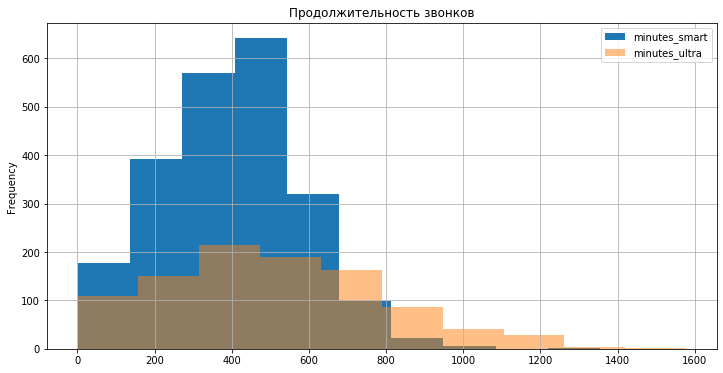

In [96]:
smart['minutes_smart'].plot(kind= 'hist', figsize = (12,6), legend=True)
ultra['minutes_ultra'].plot(kind= 'hist',figsize = (12,6), legend=True, alpha = 0.5, grid=True,title = 'Продолжительность звонков')
plt.show()

На тарифе Смарт люди разговаривают в месяц в течение 250-550 минут. Медиана равна 395 минут.

Абоненты на 75% используют свой лимит по звонкам
С тарифом Ультра другая ситуация - большая часть пользователей вообще не разговаривает голосом. Из тех, кто разговаривает, в среднем наговаривают 513 минут.

В итоге тариф ультра более разговорчив, чем тариф смарт)

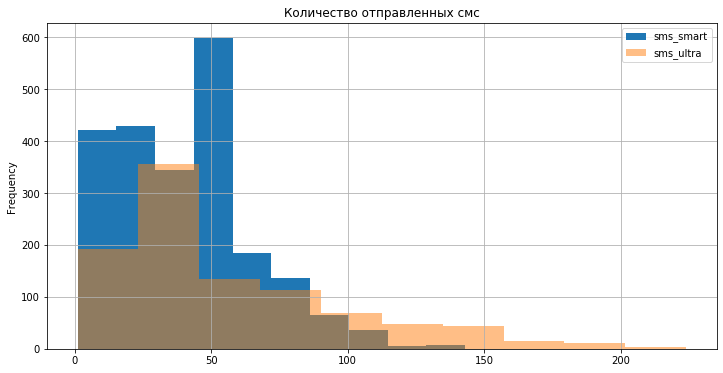

In [97]:
smart['sms_smart'].plot(kind= 'hist', figsize = (12,6), legend=True)
ultra['sms_ultra'].plot(kind= 'hist',figsize = (12,6), legend=True, alpha = 0.5, grid=True,title = 'Количество отправленных смс')
plt.show()

Большая часть пользователей и того и другого тарифане отправляет СМС сообщения, но из тех, кто отправляет, больштнство пользователи тарифа Смарт - в среднем они отправляют до 58 СМС в месяц. Пользователи тарифа  отправляют до 40 СМС.

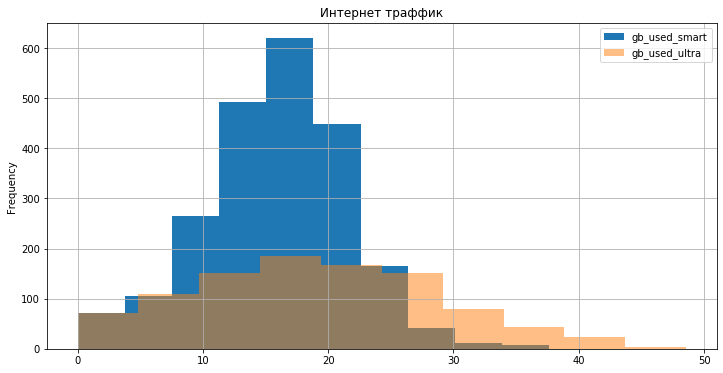

In [98]:
smart['gb_used_smart'].plot(kind= 'hist', figsize = (12,6), legend=True)
ultra['gb_used_ultra'].plot(kind= 'hist',figsize = (12,6), legend=True, alpha = 0.5, grid=True,title = 'Интернет траффик')
plt.show()

Клиенты с тарифом Смарт в среднем в месяц используют от 12 до 22 Гб трафика. Причем медиана равна 15.8 Гб, что "вылезает" за пределы, установленные абонентской платой - в 15 Гб. Фактически, клиенты тарифа Смарт  регулярно заказывают доп. пакеты с интернетом, когда основной пакет заканчивается.
Клиенты с тарифом Ультра активней пользуются интернетом - медиана равна 19 Гб, но учитывая лимит в 30 Гб, у них есть ещё большой запас по количеству оставшегося для использования трафика.

## Проверка гипотез

## Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Нулевая гипотеза -  в данном случае, что средняя выручка пользователей тарифа Смарт не отличается 
от средней выручки пользователей тарифа Ультра.

Альтернативная гипотеза - средняя выручка пользователей тарифа Смарт отличается 
от средней выручки пользователей тарифа Ультра.

In [99]:
# собирем списки выручки по месяцам для тарифа смарт
smart_table=smart.pivot_table(index = 'month', values = 'month_$', aggfunc = 'mean')
smart_mean = smart_table['month_$']
smart_mean

month
April         939.758929
August       1291.136170
December     1533.762611
February      811.258621
January       719.294118
July         1192.860697
June         1176.524390
March        1134.857143
May          1172.617021
November     1308.462025
October      1331.323129
September    1216.103846
Name: month_$, dtype: float64

In [100]:
# собирем списки выручки по месяцам для тарифа смарт

ultra_table=ultra.pivot_table(index = 'month', values = 'month_$', aggfunc = 'mean')
ultra_mean = ultra_table['month_$']
ultra_mean

month
April        2001.818182
August       2083.177570
December     2138.848921
February     1975.000000
January      1950.000000
July         2118.131868
June         2039.285714
March        2014.864865
May          2059.701493
November     2092.164179
October      2065.853659
September    2024.347826
Name: month_$, dtype: float64

In [101]:
from scipy import stats as st

In [102]:
# Выборки у нас независимые, исполь ttest_ind 


alpha = .05 
    
results = st.ttest_ind(ultra_mean, smart_mean)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение:  6.933518982669393e-12
Отвергаем нулевую гипотезу


In [103]:
df_tar

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Абоненты тарифа Ультра приносят больше денег - абонентская плата в 3,5 раза выше,
чем абонентская плата Смарт (1950р. против 550р.). 

Абоненты  Смарт часто выходят за рамки  тарифа и заказывают дополнительные услуги, 
но тем не менее не догоняют по затратам абонента Ультра.

## Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [104]:
#  Категоризируем абонентов, которые находятся в Москве (1) и за ее пределами (0), и запишем в столбец 'moscow_or_not'
df_group['moscow_or_not'] = np.where(df_group['city'] == "Москва", 1, 0)
df_group.sample(10)

,user_id,month,vyzov,minutes,sms,gb_used,tariff,city,ap,minutes_over,sms_over,gb_over,month_over,month_$,over_or_no_over,moscow_or_not
85,1011,November,52.0,475.08,12,24.707988,smart,Самара,550,0.00,0,9.707988,2000,2550,1,0
400,1063,September,96.0,772.79,45,25.185215,ultra,Тула,1950,0.00,0,0.000000,0,1950,0,0
2122,1335,August,85.0,716.83,105,18.237939,ultra,Москва,1950,0.00,0,0.000000,0,1950,0,1
619,1098,July,59.0,467.53,7,20.934707,smart,Челябинск,550,0.00,0,5.934707,1200,1750,1,0
2864,1447,November,72.0,610.22,64,18.633740,smart,Москва,550,110.22,14,3.633740,1175,1725,1,1
1514,1239,June,32.0,291.79,17,9.745508,smart,Самара,550,0.00,0,0.000000,0,550,0,0
2844,1440,November,19.0,156.14,97,17.303633,ultra,Москва,1950,0.00,0,0.000000,0,1950,0,1
1603,1252,December,53.0,506.36,20,17.298350,smart,Ростов-на-Дону,550,6.36,0,2.298350,621,1171,1,0
2038,1321,November,56.0,423.23,30,18.754414,smart,Москва,550,0.00,0,3.754414,800,1350,1,1
2307,1365,November,70.0,589.31,46,23.391934,smart,Ростов-на-Дону,550,89.31,0,8.391934,2070,2620,1,0


In [105]:
# Соберем таблицу для абонентов из Москвы и узнаем средюю вырочку за месяц
moscow= df_group.query('moscow_or_not == "1"')
moscow_mean = moscow.pivot_table(index = 'month', values = 'month_$', aggfunc = 'mean')
moscow_mean

,month_$
month,
April,1491.310345
August,1580.774194
December,1617.843750
February,1168.928571
January,1475.000000
July,1429.982143
June,1484.319149
March,1633.100000
May,1457.128205


In [106]:
# Соберем таблицу для абонентов из других городов и узнаем средюю вырочку за месяц
other= df_group.query('moscow_or_not == "0"')
other_mean = other.pivot_table(index = 'month', values = 'month_$', aggfunc = 'mean')
other_mean

,month_$
month,
April,1247.137681
August,1529.675000
December,1733.855263
February,1148.352941
January,863.028571
July,1493.372881
June,1465.109453
March,1375.234043
May,1458.644970


In [107]:
# Выборки у нас независимые, bcgjkmpetv ttest_ind 


alpha = .05 
    
results = st.ttest_ind(moscow_mean, other_mean)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  [0.23377174]
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получается.
Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод

In [108]:
smart.describe()

,user_id,vyzov,minutes_smart,sms_smart,gb_used_smart,ap,minutes_over,sms_over,gb_over,month_over,month_$,over_or_no_over
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.0,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,47.132167,395.977739,39.581875,15.836068,550.0,30.667716,5.799910,2.691964,707.768057,1257.768057,0.731718
std,146.119496,20.851171,178.410953,24.968115,5.723108,0.0,71.355286,13.442456,3.509194,800.801790,800.801790,0.443164
min,1001.000000,1.000000,1.370000,1.000000,0.000000,550.0,0.000000,0.000000,0.000000,0.000000,550.000000,0.000000
25%,1121.000000,32.000000,268.970000,20.000000,12.354844,550.0,0.000000,0.000000,0.000000,0.000000,550.000000,0.000000
50%,1239.000000,48.000000,399.380000,40.000000,16.121719,550.0,0.000000,0.000000,1.121719,412.000000,962.000000,1.000000
75%,1376.000000,61.000000,515.070000,51.000000,19.573174,550.0,15.070000,1.000000,4.573174,1183.000000,1733.000000,1.000000
max,1499.000000,162.000000,1354.220000,143.000000,37.648877,550.0,854.220000,93.000000,22.648877,6064.000000,6614.000000,1.000000


In [109]:
mean_over_gb = smart['gb_over'].mean()
mean_over_sms = smart['sms_over'].mean()
mean_over_min = smart['minutes_over'].mean()
median_over = smart['month_over'].median()
median_month = smart['month_$'].median()

In [110]:
print('Среднее превышение пакета интернет по тарифу "Смарт"', format(mean_over_gb))
print('Среднее превышение пакета минут по тарифу "Смарт"',format(mean_over_min))
print('Среднее превышение пакета СМС по тарифу "Смарт"',format(mean_over_sms))
print('Медианная доплата по тарифу "Смарт"',format(median_over))
print('Медианные затраты по тарифу "Смарт"',format(median_month))

Среднее превышение пакета интернет по тарифу "Смарт" 2.6919636435841676
Среднее превышение пакета минут по тарифу "Смарт" 30.667716464782412
Среднее превышение пакета СМС по тарифу "Смарт" 5.799910273665321
Медианная доплата по тарифу "Смарт" 412.0
Медианные затраты по тарифу "Смарт" 962.0


В итоге тариф Смарт является не самым выгодным для текущих абонентов. 
Постоянная докупка дополнительных услуг влечет к удоражания конечной стоимости тарифа на 708 рублей, а при учете абонентской плаnы состовляет c среднем 1260 рублей, а медианном значении 962 рубля.
Клиенты ищут более выгодные условия и могут окончательно уйти к конкурентам, а этого допустить нельзя!
Но кому-то из действующих абонентов тарифа Смарт тариф Ультра покажется слишком раздутым и дорогим. 
Исходя из средних значений докупания услуг, можно выделить услугу интернет и минуты, ползователям их чаще всего не хватает, а сумма доплат превышает стоимость тарифа на 128% ! Мне бы такое явно не понравилось...
Решением было создать тариф промежуточный между Смарт и Ультра по абоненсткой плате и абонентской платой.
В медианном значении абоненты готовы доплачивать за тариф примерно 400 рублей, а при добавлении действующей абонентской платы 550 мы получаем 950 рублей.
За эти деньги можно предложить более выгодные условия, по сравнению с тарифом Смарт, опираясь на "боли"абонента.
Таким образом Мегалайн сохранит своих клиентов и не потеряет в выручке.
Клиенты явно оценят такой ход!